In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import models
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision.io import read_image

class ASLModel(nn.Module):
    def __init__(self, num_class, device):
        super(ASLModel, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Linear(512, num_class)
        self.model = self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
def train_one_epoch(model, train_loader, optimizer, lr_scheduler, loss_function, epoch, device):
    model.train()
    train_loss = 0.0
    print(f'[Training Epoch: {epoch+1}]')
    for input, target in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        output = model(input.to(device))
        loss = loss_function(output.to(device), target.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    lr_scheduler.step()
    train_loss /= len(train_loader)
    return train_loss

def eval_one_epoch(model, dataloader, loss_function, epoch, device, is_train=True):
    model.eval()
    correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for input, target in dataloader:
            output = model(input.to(device))
            
            # Calculate the loss
            loss = loss_function(output.to(device), target.to(device))
            test_loss += loss.item()

            # Calculate the accuracy
            predicted = torch.softmax(output, dim=1) 
            _, predicted = torch.max(predicted, 1) 
            predicted = predicted.cpu() 
            correct += target.eq(predicted).sum().item()
    test_acc = correct / len(dataloader.dataset)
    test_loss /= len(dataloader)
    set_name = 'Train' if is_train else 'Test'
    print(f'[{set_name} set] Epoch: {epoch + 1}, Accuracy: {100 * test_acc :.2f}% Loss: {loss}')
    return test_acc, test_loss

def save_on_best_acc(model, path, test_acc, best_acc):
    if best_acc == None or test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), path)
    return best_acc

In [5]:
device = "cpu" 
train_dataset = datasets.ImageFolder(
    root="./data/train",
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(10),  # Rotate the image randomly by 10 degrees
        transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1)),
    ])
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.ImageFolder(
    root="./data/test",
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

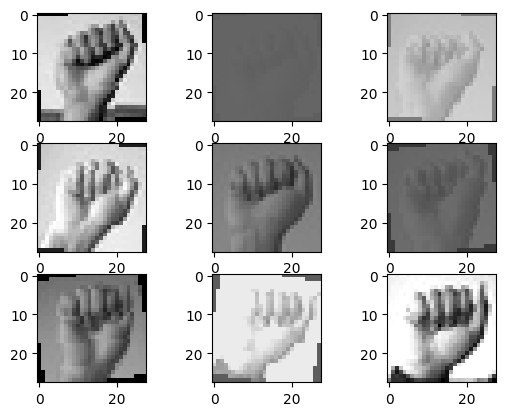

In [10]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = train_dataset[i][0].permute(1, 2, 0)
    plt.imshow(image)

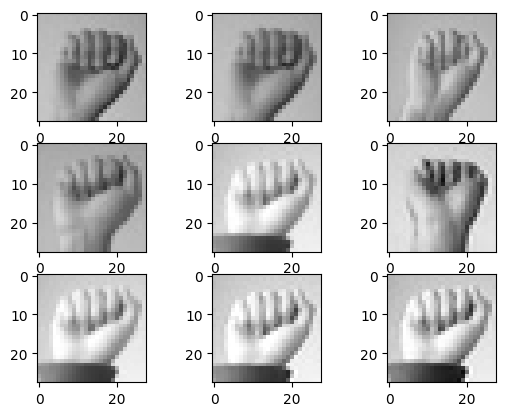

In [11]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = test_dataset[i][0].permute(1, 2, 0)
    cv2.imwrite(f'./images/test_{i}.jpg', image.numpy() * 255)
    plt.imshow(image)

In [6]:
model = ASLModel(num_class = 24, device = device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
best_acc = None
model_name = 'model_3'
train_losses, test_losses= [], []
train_accs, test_accs = [], []
for epoch in range(10):
    train_one_epoch(model, train_dataloader, optimizer, lr_scheduler, loss_function, epoch, device)
    train_acc, train_loss = eval_one_epoch(model, train_dataloader, loss_function, epoch, device, is_train=True)
    test_acc, test_loss = eval_one_epoch(model, test_dataloader, loss_function, epoch, device, is_train=False)
    best_acc = save_on_best_acc(model, f'./assets/{model_name}.pt', test_acc, best_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print("\n\n")

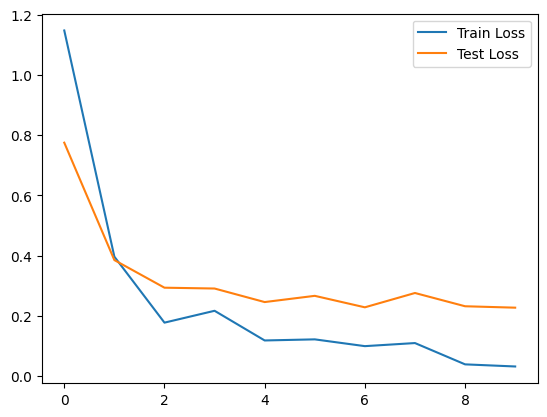

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

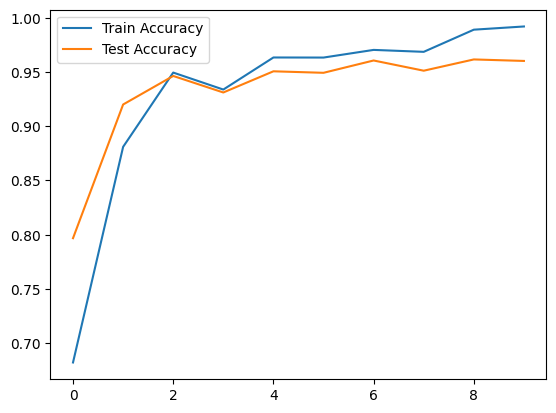

In [12]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.show()

### Double check the results

In [7]:
device = "cpu"
name = 'model_3'
model = ASLModel(num_class = 24, device = device)
model.load_state_dict(torch.load(f'./assets/{name}.pt', map_location = device))
test_dataset = datasets.ImageFolder(
    root="./data/test",
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
test_acc, test_loss = eval_one_epoch(model, test_dataloader, loss_function, 0, device, is_train=False)

[Test set] Epoch: 1, Accuracy: 96.79% Loss: 5.8114342209592e-06


In [17]:
os.makedirs('./images', exist_ok=True)
target, predicted = [], []

for i in range(200):
    torch.manual_seed(i)
    index = torch.randint(0, len(test_dataset), (1,)).item() 
    image = test_dataset[index][0]
    image = image.permute(1, 2, 0)
    target.append(test_dataset[index][1])
    cv2.imwrite(f'./images/test_{i}.jpg', image.numpy()*255)
    
for i in range(200):
    img = cv2.imread(f"./images/test_{i}.jpg")
    img = torch.from_numpy(img).float().to(device)
    img = img.permute(2, 0, 1)
    img = img.unsqueeze(0)
    img /= 255.0
    model.eval()
    output = model(img)
    logits= torch.softmax(output,dim=1)
    _, predicted_index = torch.max(logits, 1)
    predicted.append(predicted_index.item())
print(sum([1 for i in range(100) if target[i] == predicted[i]])/(100))

1.0
